### This notebook performs segmentation with a StarDist Network

In [1]:
# We import all our dependencies.
from __future__ import print_function, unicode_literals, absolute_import, division
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../../')
import numpy as np
from csbdeep.utils import plot_history, Path, normalize
from voidseg.utils.misc_utils import shuffle_train_data, augment_data
from voidseg.utils.seg_utils import fractionate_train_data
from voidseg.utils.compute_precision_threshold import compute_threshold, precision
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from scipy import ndimage
from tqdm import tqdm, tqdm_notebook
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available, _draw_polygons
from stardist.models import Config2D, StarDist2D
np.random.seed(42)
lbl_cmap = random_label_cmap()
import tensorflow as tf
import keras.backend as K
import urllib, os, zipfile, sys

Using TensorFlow backend.


### Download DSB2018 data.

From the Kaggle 2018 Data Science Bowl challenge, we take the same subset of data as has been used [here](https://github.com/mpicbg-csbd/stardist), showing a diverse collection of cell nuclei imaged by various fluorescence microscopes. We extracted 4870 image patches of size 128×128 from the training set and added Gaussian noise with mean 0 and sigma = 10 (n10), 20 (n20) and 40 (n40). This notebook shows results for n40 images.

In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/DSB.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://owncloud.mpi-cbg.de/index.php/s/LIN4L4R9b2gebDX/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

The downloaded data is in `npz` format and the cell below extracts the training, validation and test data as numpy arrays

In [3]:
trainval_data =  np.load('data/DSB/train_data/dsb2018_TrainVal40.npz')
test_data =  np.load('data/DSB/test_data/dsb2018_Test40.npz', allow_pickle=True)
train_images = trainval_data['X_train']
val_images = trainval_data['X_val']
test_images = test_data['X_test']

train_masks = trainval_data['Y_train']
val_masks = trainval_data['Y_val']
test_masks = test_data['Y_test']

In [4]:
print("Shape of train_images: ", train_images.shape, ", Shape of train_masks: ", train_masks.shape)
print("Shape of val_images: ", val_images.shape, ", Shape of val_masks: ", val_masks.shape)
print("Shape of test_images: ", test_images.shape, ", Shape of test_masks: ", test_masks.shape)

Shape of train_images:  (3800, 128, 128) , Shape of train_masks:  (3800, 128, 128)
Shape of val_images:  (670, 128, 128) , Shape of val_masks:  (670, 128, 128)
Shape of test_images:  (50,) , Shape of test_masks:  (50,)


### Data preparation for segmentation step

Next, we shuffle the raw training images and the correponding Ground Truth (GT). Then, we fractionate the training pairs of raw images and corresponding GT to realize the case where not enough annotated, training data is available. For this fractionation, please specify `fraction` parameter below. It should be between 0 (exclusive) and 100 (inclusive).

In [5]:
fraction = 2 # Fraction of annotated GT and raw image pairs to use during training. 
random_seed = 1 # Seed to shuffle training data (annotated GT and raw image pairs).


assert 0 <fraction<= 100, "Fraction should be between 0 and 100"

X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed = random_seed)
X_frac, Y_frac = fractionate_train_data(X_shuffled, Y_shuffled, fraction = 2)
print("Training Data \n..................")
X_train_aug, Y_train_aug = augment_data(X_frac, Y_frac)
print("\n")
print("Validation Data \n..................")
X_val_aug, Y_val_aug = augment_data(val_images, val_masks)

Training Data 
..................
Raw image size after augmentation (608, 128, 128)
Mask size after augmentation (608, 128, 128)


Validation Data 
..................
Raw image size after augmentation (5360, 128, 128)
Mask size after augmentation (5360, 128, 128)


Next, we do percentile normalization and fill holes in labels

In [6]:
X_train = [normalize(x,1,99.8) for x in tqdm_notebook(X_train_aug)]
Y_train = [fill_label_holes(y.astype(np.uint16)) for y in tqdm_notebook(Y_train_aug)]
X_val = [normalize(x,1,99.8) for x in tqdm_notebook(X_val_aug)]
Y_val = [fill_label_holes(y.astype(np.uint16)) for y in tqdm_notebook(Y_val_aug)]

In [7]:
X_train_filtered = []
Y_train_filtered = []
X_val_filtered = []
Y_val_filtered = []
for i in range(len(Y_train)):
    if(np.max(Y_train[i])==0):
        continue
    else:
        X_train_filtered.append(X_train[i])
        Y_train_filtered.append(Y_train[i])
for i in range(len(Y_val)):
    if(np.max(Y_val[i])==0):
        continue
    else:
        X_val_filtered.append(X_val[i])
        Y_val_filtered.append(Y_val[i])

Let's look at one of our training image and corresponding GT.

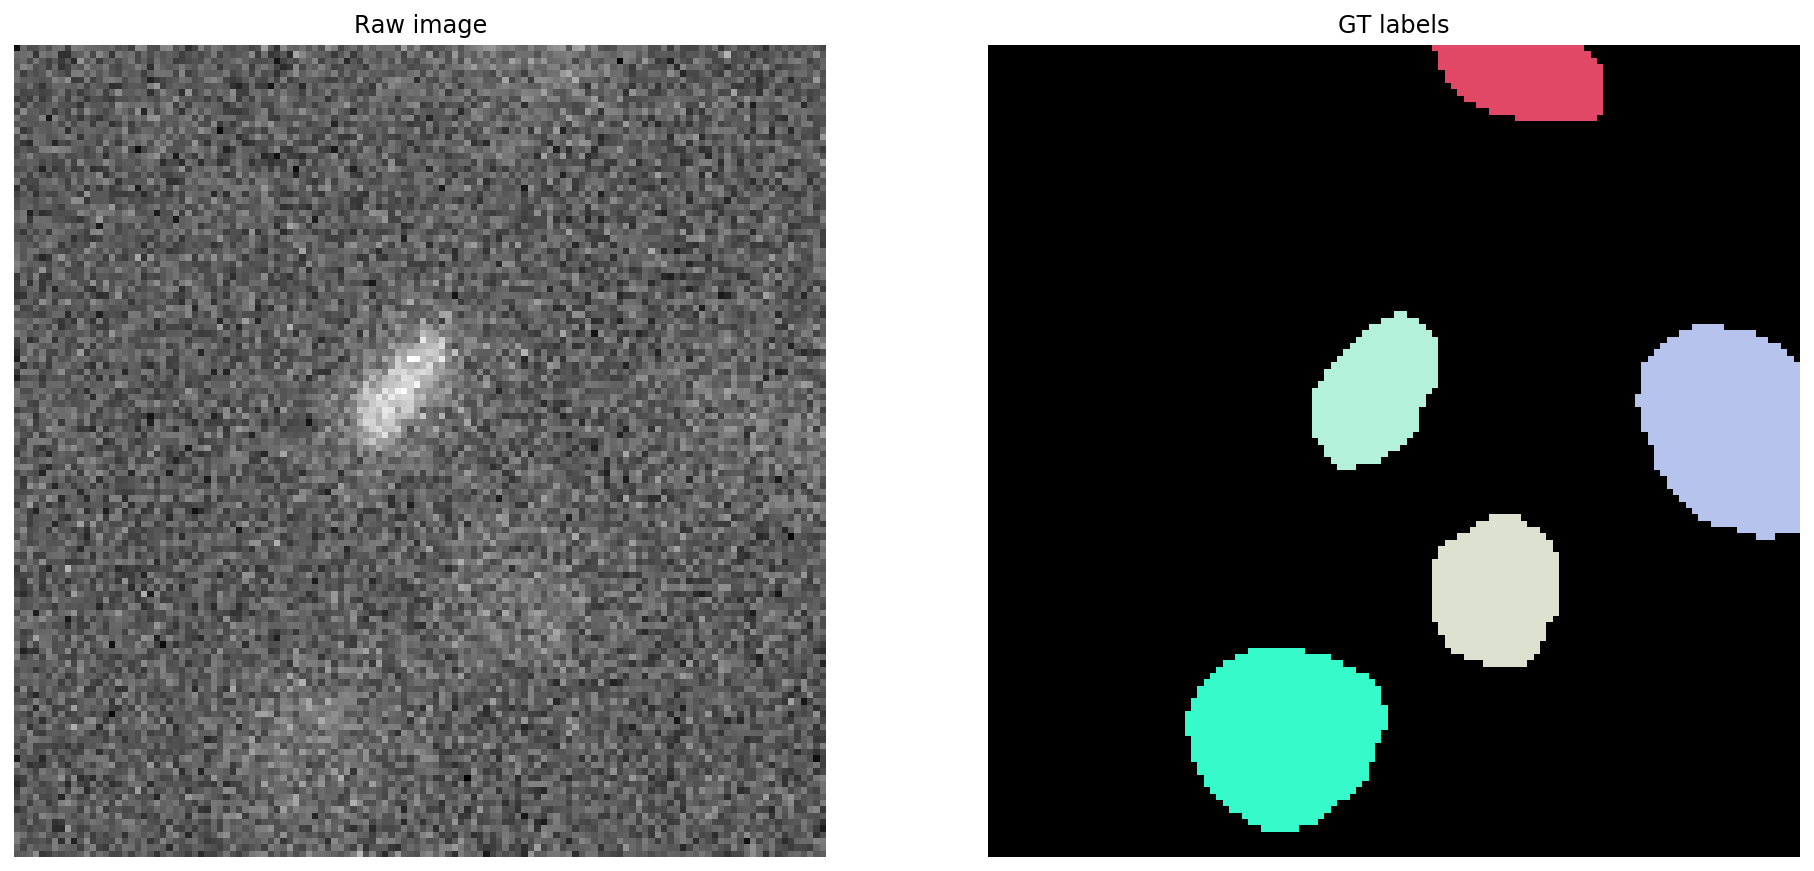

In [8]:
i = min(10, len(X_train)-1)
img, lbl = X_train[i], Y_train[i]
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;


### Configure StarDist Network

The data preparation for segmentation is now done. Next, we configure a StarDist network by specifying `Config2D` parameters. For example, one can increase `train_epochs` to get even better results at the expense of a longer computation. (This holds usually true for a large `fraction`.)

In [9]:
n_rays = 32
n_channel = 1
train_batch_size = 128
train_epochs = 15
train_learning_rate = 0.0004
train_patch_size = (64, 64)
train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}
unet_batch_norm = True
unet_n_depth = 4
train_steps_per_epoch=400
# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_batch_size = train_batch_size,
    train_epochs = train_epochs,
    train_steps_per_epoch=train_steps_per_epoch, 
    train_learning_rate = train_learning_rate,
    train_reduce_lr = train_reduce_lr,
    train_patch_size = train_patch_size,
    unet_batch_norm = unet_batch_norm,
    unet_n_depth = unet_n_depth,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=128, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=15, train_learning_rate=0.0004, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(64, 64), train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=400, train_tensorboard=True, unet_activation='relu', unet_batch_norm=True, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=4, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'unet_n_depth': 4,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': True,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (64, 64),
 'train_background_reg': 0.0001,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 15,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_n_val_patches': None,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0

In [10]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(1.0)

Now, we begin training the model for segmentation.

In [11]:
model = StarDist2D(conf, name='stardist_baseline', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [12]:
hist = model.train(X_train_filtered, Y_train_filtered, validation_data=(X_val_filtered,Y_val_filtered), augmenter=None)

Epoch 1/15
400/400 [==============================] - 90s 224ms/step - loss: 0.8887 - prob_loss: 0.1101 - dist_loss: 3.8928 - prob_kld: 0.0427 - dist_relevant_mae: 3.8925 - dist_relevant_mse: 42.4797 - val_loss: 0.7222 - val_prob_loss: 0.1401 - val_dist_loss: 2.9104 - val_prob_kld: 0.0598 - val_dist_relevant_mae: 2.9100 - val_dist_relevant_mse: 21.5343
Epoch 2/15
400/400 [==============================] - 85s 212ms/step - loss: 0.4873 - prob_loss: 0.0896 - dist_loss: 1.9888 - prob_kld: 0.0223 - dist_relevant_mae: 1.9884 - dist_relevant_mse: 10.7584 - val_loss: 0.6377 - val_prob_loss: 0.1141 - val_dist_loss: 2.6181 - val_prob_kld: 0.0339 - val_dist_relevant_mae: 2.6178 - val_dist_relevant_mse: 18.5815
Epoch 3/15
400/400 [==============================] - 85s 212ms/step - loss: 0.4186 - prob_loss: 0.0871 - dist_loss: 1.6578 - prob_kld: 0.0198 - dist_relevant_mae: 1.6573 - dist_relevant_mse: 7.4556 - val_loss: 0.6147 - val_prob_loss: 0.1200 - val_dist_loss: 2.4739 - val_prob_kld: 0.0397 -

### Computing the best threshold on validation images (to maximize Average Precision score). The threshold so obtained will be used to get hard masks from probability images to be predicted on test images.

In [13]:
threshold=compute_threshold(np.array(X_val_filtered), np.array(Y_val_filtered), model, mode = "StarDist")

Computing best threshold: 


Precision-Score for threshold = 0.10 is 0.5954
Precision-Score for threshold = 0.15 is 0.6155
Precision-Score for threshold = 0.20 is 0.6275
Precision-Score for threshold = 0.25 is 0.6354
Precision-Score for threshold = 0.30 is 0.6413
Precision-Score for threshold = 0.35 is 0.6432
Precision-Score for threshold = 0.40 is 0.6445
Precision-Score for threshold = 0.45 is 0.6435
Precision-Score for threshold = 0.50 is 0.6398
Precision-Score for threshold = 0.55 is 0.6332
Precision-Score for threshold = 0.60 is 0.6199
Precision-Score for threshold = 0.65 is 0.5951
Precision-Score for threshold = 0.70 is 0.5552
Precision-Score for threshold = 0.75 is 0.4813
Precision-Score for threshold = 0.80 is 0.3412
Precision-Score for threshold = 0.85 is 0.1619
Precision-Score for threshold = 0.90 is 0.0391
Precision-Score for threshold = 0.95 is 0.0042
Precision-Score for threshold = 1.00 is 0.0000



### Prediction on test images to get segmentation result

In [14]:
X_test_normalized = [normalize(x,1,99.8) for x in tqdm_notebook(test_images)]
precision_result = []
prediction_images = []
for i in range(len(X_test_normalized)):
    predicted_image, _ = model.predict_instances(X_test_normalized[i], prob_thresh=threshold)
    precision_result.append(precision(test_masks[i],predicted_image))
    prediction_images.append(predicted_image)
print("Average precision over all test images at IOU = 0.5: ", np.mean(precision_result))


Average precision over all test images at IOU = 0.5:  0.6661911207610812


Text(0.5, 1.0, 'Ground Truth')

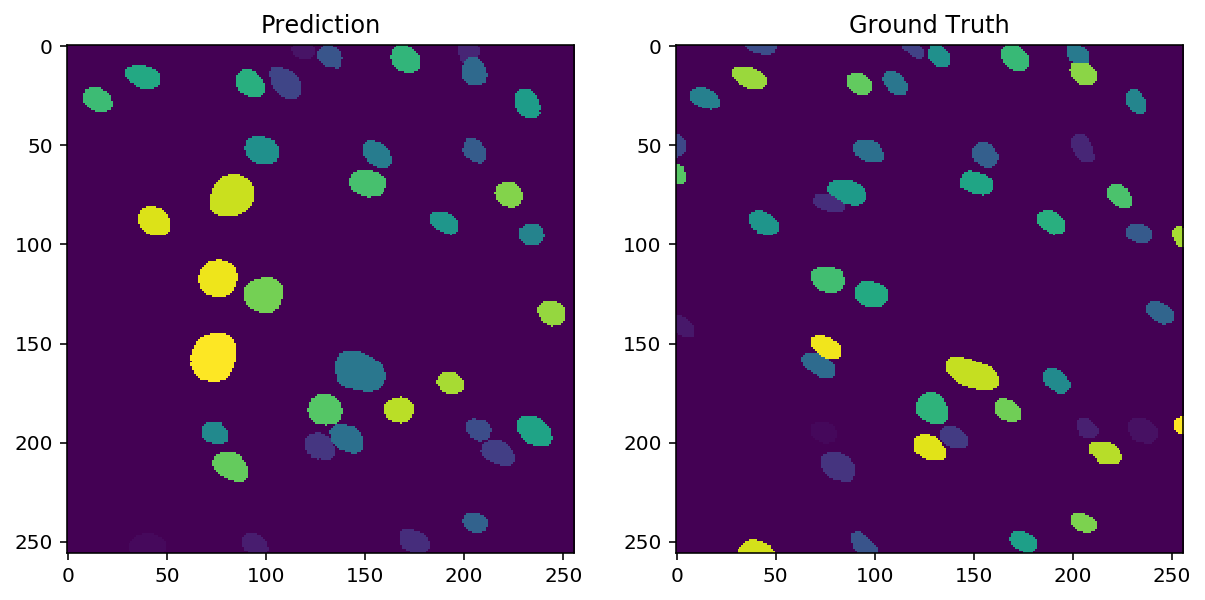

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(prediction_images[22])
plt.title('Prediction')
plt.subplot(1,2,2)
plt.imshow(test_masks[22])
plt.title('Ground Truth')